In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

pairs = [('VO','IWB'), ('VO','SCHB'), ('VO','SPY'), ('VO','SCHX'), ('VO','VOO'), ('DVY','IWR'), ('IWR','DIA'), ('DVY','OEF'), ('DVY','VYM')] # closing

# pairs = [('VO', 'VOO'), ('VTI', 'VO'), ('VO','SCHB'), ('VO','SPLG'), ('DVY','IWB'), ('DVY','IWR'), ('DVY','VTI'), ('VO','ITOT'), ('VO','IWB')] # opening

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']


/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_62809/2696793459.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  11 of 11 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_62809/2696793459.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  11 of 11 completed


In [2]:
def predict_mean_reversion_label(spread, lower, upper):
    mean = spread.mean()
    std = spread.std()
    z_scores = (spread - mean) / std

    labels = ((z_scores <= lower) | (z_scores >= upper)).astype(int)

    return pd.Series(labels, index=spread.index)

In [3]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def create_features(spread, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()
    df['z-score_lag1'] = df['z-score'].shift(1)
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag3'] = df['z-score'].shift(3)
    df['z-score_lag4'] = df['z-score'].shift(4)
    df['z-score_lag5'] = df['z-score'].shift(5)
    df['spread_lag1'] = df['spread'].shift(1)
    df['spread_lag2'] = df['spread'].shift(2)
    df['spread_lag3'] = df['spread'].shift(3)
    df['spread_lag4'] = df['spread'].shift(4)
    df['spread_lag5'] = df['spread'].shift(5)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    
    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    window = 5

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, window = window)
    test_features = create_features(testing_spread, window = window)

    train_labels = predict_mean_reversion_label(training_spread, lower = -1, upper = 1)

    train_features['label'] = train_labels.loc[train_features.index]
    train_features = train_features.dropna(subset=['label'])

    test_labels = predict_mean_reversion_label(testing_spread, lower = -1, upper = 1)
    test_features['label'] = test_labels.loc[test_features.index]
    test_features = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name] = test_features.drop(columns=['label'])
    y_test_dict[pair_name] = test_features['label']


training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [4]:
param_grid = {
    'n_neighbors': [3, 5, 7, 11, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Storage dictionaries
best_params_dict = {}
best_scores_dict = {}
knn_models = {}
scalers = {}
test_reports = {}

# Fixed random seed for reproducibility
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through all ETF pairs
for pair_name in X_train_dict.keys():
    print(f"\nGrid search KNN for {pair_name}")
    
    X_train, y_train = X_train_dict[pair_name], y_train_dict[pair_name]
    X_test, y_test = X_test_dict[pair_name], y_test_dict[pair_name]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scalers[pair_name] = scaler
    
    # Grid search with 5-fold CV
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)
    
    # Store best parameters & CV score
    best_params_dict[pair_name] = grid_search.best_params_
    best_scores_dict[pair_name] = grid_search.best_score_
    
    # Evaluate on test set
    best_knn = grid_search.best_estimator_
    knn_models[pair_name] = best_knn
    y_pred = best_knn.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    test_reports[pair_name] = {
        'accuracy': acc,
        'report': report
    }

    print(best_params_dict[pair_name])

print("\nGrid Search Completed for All Pairs")


Grid search KNN for VO_IWB
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Test Accuracy: 0.5280
              precision    recall  f1-score   support

           0       0.81      0.37      0.50       822
           1       0.41      0.84      0.55       430

    accuracy                           0.53      1252
   macro avg       0.61      0.60      0.53      1252
weighted avg       0.67      0.53      0.52      1252

{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}

Grid search KNN for VO_SCHB
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Test Accuracy: 0.6118
              precision    recall  f1-score   support

           0       0.92      0.48      0.63       860
           1       0.44      0.90      0.59       392

    accuracy                           0.61      1252
   macro avg       0.68      0.69      0.61      1252
weighted avg       0.77      0.61      0.62      1252

{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'un

In [5]:
results = {}

for pair_name in X_train_dict.keys():
    # Get trained KNN and scaler
    knn_model = knn_models[pair_name]
    scaler = scalers[pair_name]

    # Scale test set
    X_test_scaled = scaler.transform(X_test_dict[pair_name])
    y_test = y_test_dict[pair_name]

    # Predict probabilities (use predict_proba for KNN)
    # probs[:, 1] is the probability of class 1
    probs = knn_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_label = knn_model.predict(X_test_scaled)

    # Store in results dict
    results[pair_name] = {
        'model': knn_model,
        'y_true': y_test.values,
        'y_pred': probs  # store probabilities for portfolio simulation
    }

print("Results dictionary ready for portfolio simulation")

Results dictionary ready for portfolio simulation


In [6]:
def build_prices(pair_list, testing_data, X_test_dict):
    test_prices_dict = {}

    for pair in pair_list:
        etf1, etf2 = pair.split('_')

        data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Low']]
        new_data = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4

        price_df = new_data[[etf1, etf2]].copy()
        price_df.columns = ['price_long', 'price_short']

        test_index = X_test_dict[pair].index
        aligned_prices = price_df.loc[test_index]

        test_prices_dict[pair] = aligned_prices

    return test_prices_dict

In [7]:
def compute_max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdowns = equity_curve / running_max - 1.0
    max_drawdown = drawdowns.min()
    
    return max_drawdown, drawdowns

In [8]:
def simulate_portfolio(
    X_df, y_pred_label, prices_df,
    initial_cash_per_pair=100.0,
    holding_period=15,
    entry_threshold=1,
):

    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    df['label'] = y_pred_label
    df = df.join(prices_df)

    # Start with fixed capital
    cash = initial_cash_per_pair
    equity = pd.Series(index=df.index, dtype=float)
    equity.iloc[0] = cash
    trades = []

    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        label = row['label']
        zscore = row['z-score']
        price_long_in = row['price_long']
        price_short_in = row['price_short']

        # Only enter if KNN predicts reversion (label=1) and zscore strong
        if (label == 1 and abs(zscore) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price_long_out = df.iloc[exit_idx]['price_long']
            price_short_out = df.iloc[exit_idx]['price_short']

            # Now the notional is ALL accumulated cash
            notional = cash
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if zscore > 0:
                # Short ETF1, Long ETF2
                shares_short_long = short_dollars / price_long_in
                shares_long_short = long_dollars / price_short_in

                pnl = (shares_long_short * (price_short_out - price_short_in)) + \
                      (shares_short_long * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                # Long ETF1, Short ETF2
                shares_long_long = long_dollars / price_long_in
                shares_short_short = short_dollars / price_short_in

                pnl = (shares_long_long * (price_long_out - price_long_in)) + \
                      (shares_short_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[exit_date] = cash

            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "direction": direction,
                "pnl": pnl,
                "notional": notional
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace=True)
    return equity, trades

In [11]:
def run_simulation(results, X_test_dict, testing_data, initial_cash_per_pair=100.0):
    pair_list = list(X_test_dict.keys())
    test_prices_dict = build_prices(pair_list, testing_data, X_test_dict)

    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}
    pair_drawdowns = {}
    pair_equities = {}

    plt.figure(figsize=(12, 6))

    for pair_name in pair_list:
        model_info = results[pair_name]
        model = model_info['model']
        y_true = model_info['y_true']
        y_pred_label = model_info['y_pred']  # KNN labels directly (0/1)

        prices_df = test_prices_dict[pair_name]
        X_test_df = X_test_dict[pair_name]

        # Run cumulative reinvestment simulation
        equity, trades = simulate_portfolio(
            X_test_df,
            y_pred_label,
            prices_df,
            initial_cash_per_pair=initial_cash_per_pair
        )

        pair_equities[pair_name] = equity
        max_dd, _ = compute_max_drawdown(equity)
        pair_drawdowns[pair_name] = max_dd

        pair_returns = equity.pct_change().dropna()
        sharpe = (pair_returns.mean() / pair_returns.std()) * np.sqrt(252) if pair_returns.std() != 0 else np.nan
        pair_sharpes[pair_name] = sharpe

        total_cash += equity.iloc[-1]
        pair_trade_counts[pair_name] = len(trades)
        pair_pnls[pair_name] = [t['pnl'] for t in trades]

        # Combine equities for plotting
        if combined_equity.empty:
            equity.name = pair_name
            combined_equity = equity.to_frame()
        else:
            equity.name = pair_name
            combined_equity = pd.concat([combined_equity, equity], axis=1)

        sns.lineplot(x=equity.index, y=equity.values, label=pair_name)

    combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')
    combined_equity['Total'] = combined_equity.sum(axis=1)


    plt.title("KNN Equity Curve by Pair", fontsize=15, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value ($)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    yearly = combined_equity.resample('YE').last()
    print("\nYear-End Portfolio Values:")
    print(yearly)

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"{pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity['Total'].pct_change().dropna()
    total_sharpe = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {total_sharpe:.2f}")

    print("\nMax Drawdowns by Pair:")
    for pair, drawdown in pair_drawdowns.items():
        print(f"{pair}: Max Drawdown = {drawdown:.2%}")

    max_dd, drawdowns = compute_max_drawdown(combined_equity['Total'])
    print(f"\nTotal Max Drawdown: {max_dd:.2%}")

    for pair in combined_equity.columns:
        print(f"Pair: {pair}")
        print(combined_equity[pair].tail(10))  # last 10 rows
        print("-" * 40)

    # Save cumulative equity
    cumulative_equity = combined_equity['Total']
    cumulative_equity.to_csv("knn_equity.csv", header=["Portfolio Value"])

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_62809/3354488015.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Low']]
[*********************100%***********************]  11 of 11 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_62809/3354488015.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Low']]
[*********************100%***********************]  11 of 11 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_62809/3354488015.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High',

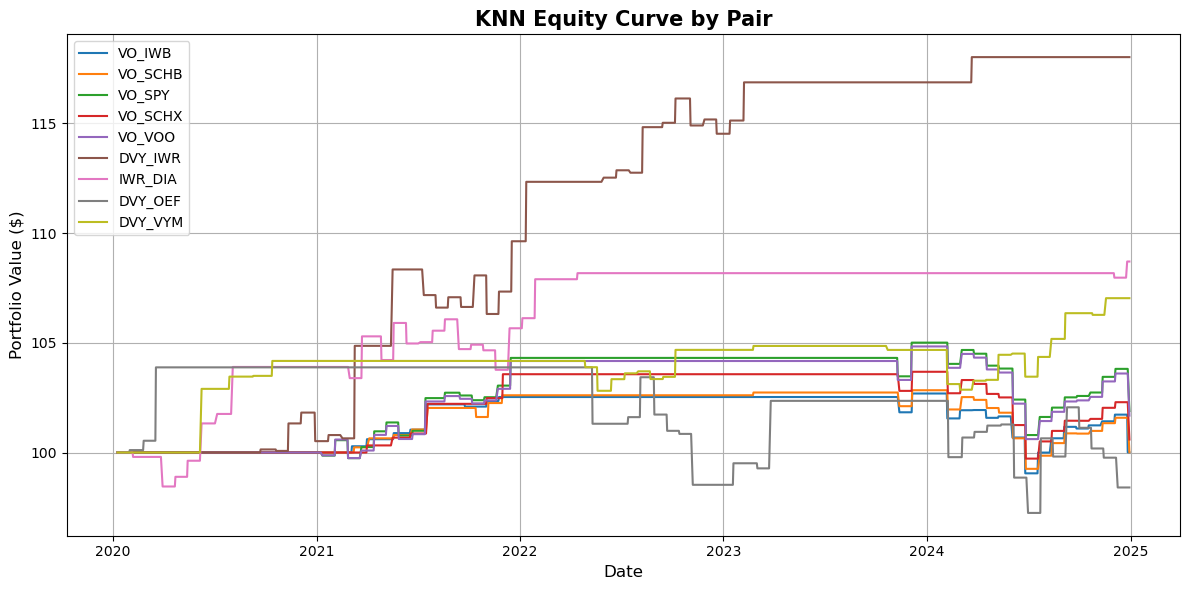


Final Portfolio Value: $936.35

Trade Summary:
  VO_IWB: 25 trades | Total PnL: $0.01 | Avg PnL: $0.00
  VO_SCHB: 26 trades | Total PnL: $0.01 | Avg PnL: $0.00
  VO_SPY: 32 trades | Total PnL: $1.89 | Avg PnL: $0.06
  VO_SCHX: 24 trades | Total PnL: $0.59 | Avg PnL: $0.02
  VO_VOO: 32 trades | Total PnL: $1.68 | Avg PnL: $0.05
  DVY_IWR: 30 trades | Total PnL: $18.02 | Avg PnL: $0.60
  IWR_DIA: 25 trades | Total PnL: $8.71 | Avg PnL: $0.35
  DVY_OEF: 27 trades | Total PnL: $-1.59 | Avg PnL: $-0.06
  DVY_VYM: 26 trades | Total PnL: $7.03 | Avg PnL: $0.27

Year-End Portfolio Values:
                VO_IWB     VO_SCHB      VO_SPY     VO_SCHX      VO_VOO  \
Date                                                                     
2020-12-31  100.000000  100.000000  100.000000  100.000000  100.000000   
2021-12-31  102.528881  102.609543  104.312192  103.568518  104.170440   
2022-12-31  102.528881  102.609543  104.312192  103.568518  104.170440   
2023-12-31  102.689283  102.838829  105.0

In [12]:
run_simulation(results, X_test_dict, testing_data)